In [2]:
from zero.imports import *
from zero.core import *

/home/fengwf/anaconda3/envs/zero/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fengwf/anaconda3/envs/zero/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fengwf/anaconda3/envs/zero/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/fengwf/anaconda3/envs/zer

### Generate random Directed Acyclic Graphs (DAG)
There are many models to generate random graphs, but not enough models to generate random Directed Acyclic Graphs. 

One kind of methodology is first generating random undirected graphs, then translate to DAGs by sorting all the nodes.
The other kind of methodology is generating random DAGs directly.

#### First generating random undirected graphs, then translate to DAGs

In [101]:
#export
def build_graph(model:str=None, n:int=None, p:float=None, m:int=None, k:int=None):
    """
    Generating undirected random graphs according to several common models

    Parameters:
    -----------

    model : collection of random models: 
            ER - 
            BA -
            PC - Powerlaw-Clustering
            WS - 
    n     : number of nodes
    p     : the probability of clustering in PC model, the probability of rewiring in WS model
    m     : the number of new nodes added at each step, both in BA and PC models
    k     : the average degree of all nodes both in ER model and in WS model
    """
    is_connected = False
    while not is_connected:
        if model == 'ER':
            G = nx.random_graphs.gnm_random_graph(n, k * n)
        elif model == 'BA':
            G = nx.random_graphs.barabasi_albert_graph(n, m)
        elif model == 'PC':  # Powerlaw-Clustering
            G = nx.random_graphs.powerlaw_cluster_graph(n, m, p)
        elif model == 'WS':
            G = nx.random_graphs.connected_watts_strogatz_graph(n, k*2, p, tries=200)
        is_connected = nx.is_connected(G)
        G.graph['n'] = n
    return G

In [102]:
#export
def to_DAG(G):
    """Translate an undirected graph to DAG."""
    # first, translated to a directed graph, 
    # where one undirected edge is tranformed to two directed edges
    G = G.to_directed() 
    # then, delete edges whose input node is larger than its output node.
    removed_edges = [(u,v) for (u,v) in G.edges if u >= v]  
    G.remove_edges_from(removed_edges)
    assert nx.dag.is_directed_acyclic_graph(G) #
    return G


In [113]:
model = 'ER'; n = 10; k = 2; p = m = None
#model = 'WS'; n = 40; k = 4; p = 0.5; m = None
#model = 'BA'; n = 100; m = 4; k = p = None
#model = 'PC'; n =100; m = 4; p = 0.75; k = None
G = build_graph(model=model, n=n, p=p, m=m, k=k)
print(G.number_of_edges())
G = to_DAG(G)

20


#### Niche models
 1. Niche model in food webs
 2. Trophic coherent in food webs


The niche model uses two fundamental parameters, connectance and number of species, and relies on a one-dimensional niche space or hierarchy. 
Species are given a random niche value $n_i \sim Uniform(0,1)$ in the hierarchy.
Diets are assigned to each species independently by generating a center and a range as follows. 
Firstly, the feeding range is given by $r_i = n_i x_i$ where $x_i$ is a random number drawn from a Beta distribution, with equation $x_i \sim Beta(\alpha=1,\beta)$. The distribution is chosen to obtain, on average, the desired connectance. 
Secondly, the centers of the feeding ranges are chosen randomly from species further down in the hierarchy, with equation $c_i \sim Uniform (r_i/2,n_i)$. Once a feeding range is established for a given species, all species in that range become its prey. 

In [146]:
#export
def niche(s:int, c:int, flip_diag:bool=True):
    """
    Niche Model for Food Web
    
    Args:
    s: number of species in the community
    c: the connectance, or fraction of realized links in the food web
    
    Returns:
    a weakly connected DAG (Directed Acyclic Graph) for a niche model food web.
    """
    weakly_connected = False
    while not weakly_connected:
        b = 1 / (2 * c) - 1
        ni = sorted(np.random.uniform(size = s))
        ri = np.random.beta(a = 1, b = b, size = s) * ni
        ci = np.random.uniform(size = s, low = ri / 2, high = np.minimum(ni, 1 - ri / 2))
        A = np.zeros((s,s))
        for i in range(s):
            for j in range(i+1, s): # 1
                if ni[i] > ci[j] - .5 * ri[j] and ni[i] < ci[j] + .5 * ri[j]:
                    A[i,j] = 1
        if flip_diag:
            A = np.flip(np.rot90(A), axis=1) # rotate 90 degree anti-clockly, then flip along column
        G=nx.from_numpy_matrix(A, create_using=nx.DiGraph())
        weakly_connected = nx.is_weakly_connected(G)
    G.graph['n'] = s
    G.graph['c'] = c
    return G  #A,   

In [149]:
G = niche(100, 0.05, flip_diag=True)

### Add an unique input node and an unique output node for DAG

In [114]:
#export

def after_DAG(G, option:str=None):
    """
    Add an unique input node and an unique output node for DAG.
    There are two options to add these two new nodes.
    First is to connect the new input node to nodes which have zero input degree in the origin DAG,
    and connect nodes which have zero output degree to the new output node.
    Second is to connect the new input node to all nodes in the origin DAG,
    and connect all node in the origin DAG to the new output node.
    """
    n = G.graph['n'] # number of nodes
    
    # find all input nodes and output nodes
    if option == 'all':
        in_nodes = out_nodes = range(n)
    else:
        in_nodes = [v for v, d in G.in_degree() if d==0]
        out_nodes = [v for v, d in G.out_degree() if d==0]
    # number of input nodes, number of output nodes, length of longest path
    # len(in_nodes), len(out_nodes), 

    # add a node with id: -1 as the unique input node
    in_edges = [(-1,i) for i in in_nodes] 
    G.add_edges_from(in_edges)
    # add a node with id: n as the unique output node
    out_edges = [(i, n) for i in out_nodes] 
    G.add_edges_from(out_edges)
    
    return G

In [115]:
G = after_DAG(G, option='all')

In [116]:
for id in G.nodes():
    print(id, end=',')

0,1,2,3,4,5,6,7,8,9,-1,10,

In [117]:
nx.is_directed_acyclic_graph(G), nx.dag.dag_longest_path_length(G)

(True, 6)

### Summary of random DAGs

Summary information of a DAG. The information reflect structural features of a DAG that may influence on the performance of corresponding neural network.

In [131]:
def paths_DAG(G):
    """
    All paths from the unique input node to the unique output node.
    The DAG is first transformed to a matrix, then the number of paths 
    with length `i` can be calculated as an element of `i` power of the matrix.
    
    Returns:
    --------
    
    """
    n = nx.number_of_nodes(G) # get node number
    
    # first, tranform to matrix, nodes are sorted by their IDs
    mat = nx.to_numpy_matrix(G, nodelist=sorted(G.nodes()))
    
    start = True
    paths = OrderedDict() # key: the length of paths, value: the number of paths with particular length
    for i in range(1, n):
        mat_power = matrix_power(mat,i)
        num_paths = int(mat_power[0,-1]) # number of paths with length `i` from the input node to the output node
        if num_paths != 0 and start: # paths with the least length
            start = False
            paths[i] = num_paths
        elif num_paths == 0 and not start: # after the longest length
            break
        else:
            paths[i] = num_paths
    return paths

In [139]:
paths_DAG(G)

OrderedDict([(1, 0), (2, 10), (3, 20), (4, 17), (5, 10), (6, 4)])

In [144]:
#export
def summary_DAG(G):
    """
    Summary information of a DAG. The information reflect structural features of
    a DAG that may influence on the performance of corresponding neural network.
    
    Returns:
    --------
    
    num_nodes : number of nodes
    num_edges : number of edges
    num_real_nodes : number of real nodes, except the unique input and output nodes.
    
    average clustering : (undirected)
    transitivity : (undirected)
    transitivity : (directed)

    in_nodes : list of IDs of all input nodes.
    num_in_nodes : number of input nodes.
    out_nodes : list of IDs of all output nodes.
    num_out_nodes : number of output nodes.
    
    paths : dict of all paths from the input node to the output node
    max_length : max length of all path from the input node to the output node
    num_paths : number of all paths from the input node to the output node
    
    """
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    num_real_nodes = G.graph['n']
    
    average_clustering = nx.average_clustering(nx.to_undirected(G))
    transitivity = nx.transitivity(nx.to_undirected(G))
    transitivity_directed = nx.transitivity(G)
    
    # find all input nodes and output nodes
    in_nodes = [v for v, d in G.in_degree() if d==0]
    num_in_nodes = len(in_nodes)
    out_nodes = [v for v, d in G.out_degree() if d==0]
    num_out_nodes = len(out_nodes)

    path_lens = path_counts = num_paths = None
    
    #if the unique input node and the unique output node have been added
    if num_in_nodes == 1 and num_out_nodes == 1 and num_real_nodes != num_nodes:
        in_nodes = [*G.successors(-1)]
        num_in_nodes = len(in_nodes)
        out_nodes = [*G.predecessors(G.graph['n'])]
        num_out_nodes = len(out_nodes)
        
        paths = paths_DAG(G)
        max_length = max(paths.keys())
        num_paths = sum(paths.values())
#         paths = nx.all_simple_paths(G, source=-1, target=num_real_nodes)
#         len_paths = [len(path)-1 for path in paths]
#         len_paths = np.array(len_paths)
#         path_lens, path_counts = np.unique(len_paths, return_counts=True)
#         num_paths = len(len_paths)
        
    print(' number of nodes :', num_nodes, '\n',
          'number of edges :', num_edges, '\n',
          'average node degree : %.4f' % (num_edges/num_nodes), '\n',
          'number of real nodes :', num_real_nodes, '\n',
          'average clustering (undirected) : %.4f' % average_clustering, '\n',
          'transitivity (undirected) : %.4f' % transitivity, '\n',
          'transitivity (directed) : %.4f' % transitivity_directed, '\n',
          'input nodes : ', in_nodes, '\n',
          'number of input nodes :', num_in_nodes, '\n',
          'output nodes : ', out_nodes, '\n',
          'number of output nodes :', num_out_nodes, '\n',
          'all paths :', paths, '\n',
          'max length of all paths :', max_length, '\n',
          'number of all paths :', num_paths, '\n')

In [145]:
summary_DAG(G)

 number of nodes : 12 
 number of edges : 40 
 average node degree : 3.3333 
 number of real nodes : 10 
 average clustering (undirected) : 0.6197 
 transitivity (undirected) : 0.5633 
 transitivity (directed) : 0.2556 
 input nodes :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 number of input nodes : 10 
 output nodes :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 number of output nodes : 10 
 all paths : OrderedDict([(1, 0), (2, 10), (3, 20), (4, 17), (5, 10), (6, 4)]) 
 max length of all paths : 6 
 number of all paths : 61 



### Visualization of random DAGs

/home/fengwf/anaconda3/envs/zero/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/fengwf/anaconda3/envs/zero/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


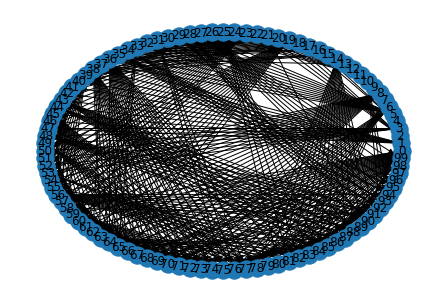

In [151]:
nx.draw(G ,pos=nx.circular_layout(G),with_labels=True)

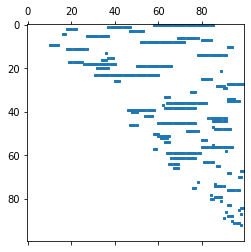

In [152]:
A = nx.to_numpy_matrix(G, nodelist=sorted(G.nodes()))
plt.spy(A, markersize=2)

### Neural networks constructed based on complex networks

In [153]:
#export
class NodeOP(nn.Module):
    """
    The Operation of every inner node in the network.
    
    Parameters:
    -----------
    ni : number of input channels
    no : number of output channels
    nh : number of hidden channels
    Unit : the operation at the node
    kwargs : arguments into `Unit`
    """
    def __init__(self, ni:int, no:int, nh:int, Unit:nn.Module, **kwargs):
        super(NodeOP, self).__init__()
        self.unit = Unit(ni, no, nh, **kwargs)
            
    def forward(self, *inputs):
        sum_inputs = sum(inputs)        
        out = self.unit(sum_inputs)
        return out
    

In [168]:
#export
import torch.utils.checkpoint as cp # checkpointing
class NetworkOP(nn.Module):
    """
    The operations along a DAG network.
    
    Parameters:
    -----------
    G   :  the `NetworkX` 'DiGraph' object, represent a DAG.
    ni  :  number of input channels of the network
    no  :  number of output channel of the network
    Unit : operation at every inner node
    stride : whether downsample or not, at the end of the network
    kwargs : arguments into `Unit`
    
    """
    def __init__(self, G:nx.DiGraph, ni:int, no:int, Unit:nn.Module, stride:int=1, **kwargs):
        super(NetworkOP, self).__init__()
        self.G = G
        self.n = G.graph['n'] # number of nodes
        self.nodeop = nn.ModuleList() # ! need improve, to Moduledict !
        for id in G.nodes(): # for each node
            if id == -1:  # if is the unique input node, do nothing
                continue
            elif id == self.n:  # if is the unique output node
                # then, concat its predecessors
                n_preds = len([*G.predecessors(id)])
                self.nodeop += [IdentityMapping(n_preds * ni, no, stride=stride)]
            else:  # if is the inner node
                self.nodeop += [NodeOP(ni, ni, ni, Unit, **kwargs)]
            
    def forward(self, x):
        results = {}
        results[-1] = x  # input data is the result of the unique input node
        for id in self.G.nodes(): # for each node
            if id == -1:  # if is the input node, do nothing
                continue
            # get the results of all predecessors
            inputs = [results[pred]  for pred in self.G.predecessors(id)]
            if id == self.n: # if is the output node
                cat_inputs = torch.cat(inputs, dim=1) # concat results of all predecessors
                return cp.checkpoint(self.nodeop[id], cat_inputs) #self.nodeop[id](cat_inputs)
            else: # if is inner nodes
                results[id] = cp.checkpoint(self.nodeop[id], *inputs) #self.nodeop[id](*inputs)

            # 删除前驱结点result中，不再需要的result
            for pred in self.G.predecessors(id):  # 获得节点的所有前驱结点
                succs = list(self.G.successors(pred))  # 获得每个前驱结点的所有后继节点
                # 如果排名最后的后继节点是当前节点，说明该前驱结点的result不再被后续的节点需要，可以删除
                if max(succs) == id:  
                    del results[pred]
        


In [169]:
#export
class ComplexNet(nn.Sequential):
    """
    Neural Network based on complex network
    
    Parameters:
    -----------
    Gs  :  a list of `NetworkX DiGraph` objects
    ns  :  number of channels of all stages
    Unit : 
    c_out : number of output channels
    kwargs : additional args into `Unit` class
    """
    def __init__(self, Gs:list, ns:list, Unit:nn.Module, c_out:int=10, **kwargs):
        super(ComplexNet, self).__init__()
        stem = conv_bn(3, ns[0])
        network_ops = []
        for i in range(len(ns)-2):
            network_ops += [NetworkOP(Gs[i], ns[i], ns[i+1], Unit, stride=2, **kwargs)]
        # the last stage has stride=1 at its end, i.e. no downsampling
        network_ops += [NetworkOP(Gs[-1], ns[-2], ns[-1], Unit, stride=1, **kwargs)]
        
        classifier = Classifier(ns[-1], c_out)
        super().__init__(
            stem,
            *network_ops,
            classifier
        )
        init_cnn(self)

In [170]:
def complexnet_32():
    species = [50,50,50,50]
    connectance = [0.05]*4
    Gs = [after_DAG(niche(s, c)) for s,c in zip(species, connectance)]
    ns = [32,32,32,32,32]
    model = ComplexNet(Gs, ns, xception)
    return model

In [171]:
model = complexnet_32()

In [167]:
num_params(model)

tensor(338154)

### Export

In [172]:
!python notebook2script.py complexnet.ipynb

Converted complexnet.ipynb to zero/complexnet.py
